In [1]:
import torch
import torch.nn as nn
from thop import profile
import os
from pathlib import Path
import pandas as pd
##---------- Basic Layers ----------
def conv3x3(in_chn, out_chn, bias=True):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1, bias=bias)
    return layer


def conv(in_channels, out_channels, kernel_size, bias=False, stride=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size,
        padding=(kernel_size // 2),
        bias=bias,
        stride=stride,
    )


def bili_resize(factor):
    return nn.Upsample(scale_factor=factor, mode="bilinear", align_corners=False)


##---------- Basic Blocks ----------
class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample):
        super(UNetConvBlock, self).__init__()
        self.downsample = downsample
        self.block = SK_RDB(in_channels=in_size, growth_rate=out_size, num_layers=3)
        if downsample:
            self.downsample = PS_down(out_size, out_size, downscale=2)

    def forward(self, x):
        out = self.block(x)
        if self.downsample:
            out_down = self.downsample(out)
            return out_down, out
        else:
            return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUpBlock, self).__init__()
        # self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, bias=True)
        self.up = PS_up(in_size, out_size, upscale=2)
        self.conv_block = UNetConvBlock(in_size, out_size, False)

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], dim=1)
        out = self.conv_block(out)
        return out


##---------- Resizing Modules (Pixel(Un)Shuffle) ----------
class PS_down(nn.Module):
    def __init__(self, in_size, out_size, downscale):
        super(PS_down, self).__init__()
        self.UnPS = nn.PixelUnshuffle(downscale)
        self.conv1 = nn.Conv2d((downscale**2) * in_size, out_size, 1, 1, 0)

    def forward(self, x):
        x = self.UnPS(x)  # h/2, w/2, 4*c
        x = self.conv1(x)
        return x


class PS_up(nn.Module):
    def __init__(self, in_size, out_size, upscale):
        super(PS_up, self).__init__()

        self.PS = nn.PixelShuffle(upscale)
        self.conv1 = nn.Conv2d(in_size // (upscale**2), out_size, 1, 1, 0)

    def forward(self, x):
        x = self.PS(x)  # h/2, w/2, 4*c
        x = self.conv1(x)
        return x


##---------- Selective Kernel Feature Fusion (SKFF) ----------
class SKFF(nn.Module):
    def __init__(self, in_channels, height=3, reduction=8, bias=False):
        super(SKFF, self).__init__()

        self.height = height
        d = max(int(in_channels / reduction), 4)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(in_channels, d, 1, padding=0, bias=bias), nn.PReLU()
        )

        self.fcs = nn.ModuleList([])
        for i in range(self.height):
            self.fcs.append(
                nn.Conv2d(d, in_channels, kernel_size=1, stride=1, bias=bias)
            )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, inp_feats):
        batch_size, n_feats, H, W = inp_feats[1].shape

        inp_feats = torch.cat(inp_feats, dim=1)
        inp_feats = inp_feats.view(
            batch_size, self.height, n_feats, inp_feats.shape[2], inp_feats.shape[3]
        )

        feats_U = torch.sum(inp_feats, dim=1)
        feats_S = self.avg_pool(feats_U)
        feats_Z = self.conv_du(feats_S)

        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        attention_vectors = torch.cat(attention_vectors, dim=1)
        attention_vectors = attention_vectors.view(
            batch_size, self.height, n_feats, 1, 1
        )

        attention_vectors = self.softmax(attention_vectors)
        feats_V = torch.sum(inp_feats * attention_vectors, dim=1)

        return feats_V


##---------- Dense Block ----------
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, I):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)
        self.sk = SKFF(out_channels, height=2, reduction=8, bias=False)

    def forward(self, x):
        x1 = self.relu(self.conv(x))
        # output = torch.cat([x, x1], 1) # -> RDB
        output = self.sk((x, x1))
        return output


##---------- Selective Kernel Residual Dense Block (SK-RDB) ----------
class SK_RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(SK_RDB, self).__init__()
        self.identity = nn.Conv2d(in_channels, growth_rate, 1, 1, 0)
        self.layers = nn.Sequential(
            *[DenseLayer(in_channels, in_channels, I=i) for i in range(num_layers)]
        )
        self.lff = nn.Conv2d(in_channels, growth_rate, kernel_size=1)

    def forward(self, x):
        res = self.identity(x)
        x = self.layers(x)
        x = self.lff(x)
        return res + x


##---------- testNet ----------
class SRMNet(nn.Module):
    def __init__(self, in_chn=3, wf=96, depth=4):
        super(SRMNet, self).__init__()
        self.depth = depth
        self.down_path = nn.ModuleList()
        self.bili_down = bili_resize(0.5)
        self.conv_01 = nn.Conv2d(in_chn, wf, 3, 1, 1)

        # encoder of UNet
        prev_channels = 0
        for i in range(depth):  # 0,1,2,3
            downsample = True if (i + 1) < depth else False
            self.down_path.append(
                UNetConvBlock(prev_channels + wf, (2**i) * wf, downsample)
            )
            prev_channels = (2**i) * wf

        # decoder of UNet
        self.up_path = nn.ModuleList()
        self.skip_conv = nn.ModuleList()
        self.conv_up = nn.ModuleList()
        self.bottom_conv = nn.Conv2d(prev_channels, wf, 3, 1, 1)
        self.bottom_up = bili_resize(2 ** (depth - 1))

        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, (2**i) * wf))
            self.skip_conv.append(nn.Conv2d((2**i) * wf, (2**i) * wf, 3, 1, 1))
            self.conv_up.append(
                nn.Sequential(
                    *[nn.Conv2d((2**i) * wf, wf, 3, 1, 1), bili_resize(2**i)]
                )
            )
            prev_channels = (2**i) * wf

        self.final_ff = SKFF(in_channels=wf, height=depth)
        self.last = conv3x3(prev_channels, in_chn, bias=True)

    def forward(self, x):
        img = x
        scale_img = img

        ##### shallow conv #####
        x1 = self.conv_01(img)
        encs = []
        ######## UNet ########
        # Down-path (Encoder)
        for i, down in enumerate(self.down_path):
            if i == 0:
                x1, x1_up = down(x1)
                encs.append(x1_up)
            elif (i + 1) < self.depth:
                scale_img = self.bili_down(scale_img)
                left_bar = self.conv_01(scale_img)
                x1 = torch.cat([x1, left_bar], dim=1)
                x1, x1_up = down(x1)
                encs.append(x1_up)
            else:
                scale_img = self.bili_down(scale_img)
                left_bar = self.conv_01(scale_img)
                x1 = torch.cat([x1, left_bar], dim=1)
                x1 = down(x1)

        # Up-path (Decoder)
        ms_result = [self.bottom_up(self.bottom_conv(x1))]
        for i, up in enumerate(self.up_path):
            x1 = up(x1, self.skip_conv[i](encs[-i - 1]))
            ms_result.append(self.conv_up[i](x1))
        # Multi-scale selective feature fusion
        msff_result = self.final_ff(ms_result)

        ##### Reconstruct #####
        out_1 = self.last(msff_result) + img

        return out_1

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.optim import lr_scheduler

# U-Net: Convolutional Networks for Biomedical Image Segmentation
# https://arxiv.org/abs/1505.04597
class UNet(nn.Module):
    def __init__(self, nch_in, nch_out, nch_ker=64, norm="bnorm"):
        super(UNet, self).__init__()

        self.nch_in = nch_in
        self.nch_out = nch_out
        self.nch_ker = nch_ker
        self.norm = norm

        if norm == "bnorm":
            self.bias = False
        else:
            self.bias = True

        """
        Encoder part
        """

        self.enc1_1 = CNR2d(
            1 * self.nch_in,
            1 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.enc1_2 = CNR2d(
            1 * self.nch_ker,
            1 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.pool1 = Pooling2d(pool=2, type="avg")

        self.enc2_1 = CNR2d(
            1 * self.nch_ker,
            2 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.enc2_2 = CNR2d(
            2 * self.nch_ker,
            2 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.pool2 = Pooling2d(pool=2, type="avg")

        self.enc3_1 = CNR2d(
            2 * self.nch_ker,
            4 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.enc3_2 = CNR2d(
            4 * self.nch_ker,
            4 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.pool3 = Pooling2d(pool=2, type="avg")

        self.enc4_1 = CNR2d(
            4 * self.nch_ker,
            8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.enc4_2 = CNR2d(
            8 * self.nch_ker,
            8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.pool4 = Pooling2d(pool=2, type="avg")

        self.enc5_1 = CNR2d(
            8 * self.nch_ker,
            2 * 8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        """
        Decoder part
        """

        self.dec5_1 = DECNR2d(
            2 * 8 * self.nch_ker,
            8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.unpool4 = UnPooling2d(pool=2, type="nearest")

        self.dec4_2 = DECNR2d(
            2 * 8 * self.nch_ker,
            8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.dec4_1 = DECNR2d(
            8 * self.nch_ker,
            4 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.unpool3 = UnPooling2d(pool=2, type="nearest")

        self.dec3_2 = DECNR2d(
            2 * 4 * self.nch_ker,
            4 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.dec3_1 = DECNR2d(
            4 * self.nch_ker,
            2 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.unpool2 = UnPooling2d(pool=2, type="nearest")

        self.dec2_2 = DECNR2d(
            2 * 2 * self.nch_ker,
            2 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.dec2_1 = DECNR2d(
            2 * self.nch_ker,
            1 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.unpool1 = UnPooling2d(pool=2, type="nearest")

        self.dec1_2 = DECNR2d(
            2 * 1 * self.nch_ker,
            1 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.dec1_1 = DECNR2d(
            1 * self.nch_ker,
            1 * self.nch_out,
            kernel_size=3,
            stride=1,
            norm=[],
            relu=[],
            drop=[],
            bias=False,
        )

    def forward(self, x):

        """
        Encoder part
        """

        enc1 = self.enc1_2(self.enc1_1(x))
        pool1 = self.pool1(enc1)

        enc2 = self.enc2_2(self.enc2_1(pool1))
        pool2 = self.pool2(enc2)

        enc3 = self.enc3_2(self.enc3_1(pool2))
        pool3 = self.pool3(enc3)

        enc4 = self.enc4_2(self.enc4_1(pool3))
        pool4 = self.pool4(enc4)

        enc5 = self.enc5_1(pool4)

        """
        Encoder part
        """
        dec5 = self.dec5_1(enc5)

        unpool4 = self.unpool4(dec5)
        cat4 = torch.cat([enc4, unpool4], dim=1)
        dec4 = self.dec4_1(self.dec4_2(cat4))

        unpool3 = self.unpool3(dec4)
        cat3 = torch.cat([enc3, unpool3], dim=1)
        dec3 = self.dec3_1(self.dec3_2(cat3))

        unpool2 = self.unpool2(dec3)
        cat2 = torch.cat([enc2, unpool2], dim=1)
        dec2 = self.dec2_1(self.dec2_2(cat2))

        unpool1 = self.unpool1(dec2)
        cat1 = torch.cat([enc1, unpool1], dim=1)
        dec1 = self.dec1_1(self.dec1_2(cat1))

        x = dec1

        return x


class CNR2d(nn.Module):
    def __init__(
        self,
        nch_in,
        nch_out,
        kernel_size=4,
        stride=1,
        padding=1,
        norm="bnorm",
        relu=0.0,
        drop=[],
        bias=[],
    ):
        super().__init__()

        if bias == []:
            if norm == "bnorm":
                bias = False
            else:
                bias = True

        layers = []
        layers += [
            Conv2d(
                nch_in,
                nch_out,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias,
            )
        ]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)


class DECNR2d(nn.Module):
    def __init__(
        self,
        nch_in,
        nch_out,
        kernel_size=4,
        stride=1,
        padding=1,
        output_padding=0,
        norm="bnorm",
        relu=0.0,
        drop=[],
        bias=[],
    ):
        super().__init__()

        if bias == []:
            if norm == "bnorm":
                bias = False
            else:
                bias = True

        layers = []
        layers += [
            Deconv2d(
                nch_in,
                nch_out,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=output_padding,
                bias=bias,
            )
        ]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.decbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.decbr(x)


class ResBlock(nn.Module):
    def __init__(
        self,
        nch_in,
        nch_out,
        kernel_size=3,
        stride=1,
        padding=1,
        padding_mode="reflection",
        norm="bnorm",
        relu=0.0,
        drop=[],
        bias=[],
    ):
        super().__init__()

        if bias == []:
            if norm == "bnorm":
                bias = False
            else:
                bias = True

        layers = []

        # 1st conv
        layers += [Padding(padding, padding_mode=padding_mode)]
        layers += [
            CNR2d(
                nch_in,
                nch_out,
                kernel_size=kernel_size,
                stride=stride,
                padding=0,
                norm=norm,
                relu=relu,
            )
        ]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        # 2nd conv
        layers += [Padding(padding, padding_mode=padding_mode)]
        layers += [
            CNR2d(
                nch_in,
                nch_out,
                kernel_size=kernel_size,
                stride=stride,
                padding=0,
                norm=norm,
                relu=[],
            )
        ]

        self.resblk = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.resblk(x)


class CNR1d(nn.Module):
    def __init__(self, nch_in, nch_out, norm="bnorm", relu=0.0, drop=[]):
        super().__init__()

        if norm == "bnorm":
            bias = False
        else:
            bias = True

        layers = []
        layers += [nn.Linear(nch_in, nch_out, bias=bias)]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)


class Conv2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(
            nch_in,
            nch_out,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, x):
        return self.conv(x)


class Deconv2d(nn.Module):
    def __init__(
        self,
        nch_in,
        nch_out,
        kernel_size=4,
        stride=1,
        padding=1,
        output_padding=0,
        bias=True,
    ):
        super(Deconv2d, self).__init__()
        self.deconv = nn.ConvTranspose2d(
            nch_in,
            nch_out,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            bias=bias,
        )

        # layers = [nn.Upsample(scale_factor=2, mode='bilinear'),
        #           nn.ReflectionPad2d(1),
        #           nn.Conv2d(nch_in , nch_out, kernel_size=3, stride=1, padding=0)]
        #
        # self.deconv = nn.Sequential(*layers)

    def forward(self, x):
        return self.deconv(x)


class Linear(nn.Module):
    def __init__(self, nch_in, nch_out):
        super(Linear, self).__init__()
        self.linear = nn.Linear(nch_in, nch_out)

    def forward(self, x):
        return self.linear(x)


class Norm2d(nn.Module):
    def __init__(self, nch, norm_mode):
        super(Norm2d, self).__init__()
        if norm_mode == "bnorm":
            self.norm = nn.BatchNorm2d(nch)
        elif norm_mode == "inorm":
            self.norm = nn.InstanceNorm2d(nch)

    def forward(self, x):
        return self.norm(x)


class ReLU(nn.Module):
    def __init__(self, relu):
        super(ReLU, self).__init__()
        if relu > 0:
            self.relu = nn.LeakyReLU(relu, True)
        elif relu == 0:
            self.relu = nn.ReLU(True)

    def forward(self, x):
        return self.relu(x)


class Padding(nn.Module):
    def __init__(self, padding, padding_mode="zeros", value=0):
        super(Padding, self).__init__()
        if padding_mode == "reflection":
            self.padding = nn.ReflectionPad2d(padding)
        elif padding_mode == "replication":
            self.padding = nn.ReplicationPad2d(padding)
        elif padding_mode == "constant":
            self.padding = nn.ConstantPad2d(padding, value)
        elif padding_mode == "zeros":
            self.padding = nn.ZeroPad2d(padding)

    def forward(self, x):
        return self.padding(x)


class Pooling2d(nn.Module):
    def __init__(self, nch=[], pool=2, type="avg"):
        super().__init__()

        if type == "avg":
            self.pooling = nn.AvgPool2d(pool)
        elif type == "max":
            self.pooling = nn.MaxPool2d(pool)
        elif type == "conv":
            self.pooling = nn.Conv2d(nch, nch, kernel_size=pool, stride=pool)

    def forward(self, x):
        return self.pooling(x)


class UnPooling2d(nn.Module):
    def __init__(self, nch=[], pool=2, type="nearest"):
        super().__init__()

        if type == "nearest":
            self.unpooling = nn.Upsample(scale_factor=pool, mode="nearest")
        elif type == "bilinear":
            self.unpooling = nn.Upsample(
                scale_factor=pool, mode="bilinear", align_corners=True
            )
        elif type == "conv":
            self.unpooling = nn.ConvTranspose2d(nch, nch, kernel_size=pool, stride=pool)

    def forward(self, x):
        return self.unpooling(x)


class Concat(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        diffy = x2.size()[2] - x1.size()[2]
        diffx = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffx // 2, diffx - diffx // 2, diffy // 2, diffy - diffy // 2])

        return torch.cat([x2, x1], dim=1)


class TV1dLoss(nn.Module):
    def __init__(self):
        super(TV1dLoss, self).__init__()

    def forward(self, input):
        # loss = torch.mean(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + \
        #        torch.mean(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
        loss = torch.mean(torch.abs(input[:, :-1] - input[:, 1:]))

        return loss


class TV2dLoss(nn.Module):
    def __init__(self):
        super(TV2dLoss, self).__init__()

    def forward(self, input):
        loss = torch.mean(
            torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])
        ) + torch.mean(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
        return loss


class SSIM2dLoss(nn.Module):
    def __init__(self):
        super(SSIM2dLoss, self).__init__()

    def forward(self, input, targer):
        loss = 0
        return loss


# Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
# https://arxiv.org/abs/1609.04802
class ResNet(nn.Module):
    def __init__(self, nch_in, nch_out, nch_ker=64, norm="bnorm", nblk=16):
        super(ResNet, self).__init__()

        self.nch_in = nch_in
        self.nch_out = nch_out
        self.nch_ker = nch_ker
        self.norm = norm
        self.nblk = nblk

        if norm == "bnorm":
            self.bias = False
        else:
            self.bias = True

        self.enc1 = CNR2d(
            self.nch_in,
            self.nch_ker,
            kernel_size=3,
            stride=1,
            padding=1,
            norm=[],
            relu=0.0,
        )

        res = []
        for i in range(self.nblk):
            res += [
                ResBlock(
                    self.nch_ker,
                    self.nch_ker,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    norm=self.norm,
                    relu=0.0,
                    padding_mode="reflection",
                )
            ]
        self.res = nn.Sequential(*res)

        self.dec1 = CNR2d(
            self.nch_ker,
            self.nch_ker,
            kernel_size=3,
            stride=1,
            padding=1,
            norm=norm,
            relu=[],
        )

        self.conv1 = Conv2d(
            self.nch_ker, self.nch_out, kernel_size=3, stride=1, padding=1
        )

    def forward(self, x):
        x = self.enc1(x)
        x0 = x

        x = self.res(x)

        x = self.dec1(x)
        x = x + x0

        x = self.conv1(x)

        return x

In [3]:
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from einops import repeat
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.vision.all import L, unsqueeze
from timm.data.mixup import Mixup
from timm.loss import (
    LabelSmoothingCrossEntropy,
    BinaryCrossEntropy,
    SoftTargetCrossEntropy,
)

from einops import rearrange


In [4]:

def normalize(x, pmin=3, pmax=97, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x


In [5]:



class SaveModel:
    def __init__(self, folder, exp_name, best=np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score < self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelMetric:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score > self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelEpoch:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder)
        self.exp_name = exp_name

    def __call__(self, score, model, epoch):
        self.best = score
        print(f"Better model found at epoch {epoch} with value: {self.best}.")
        torch.save(model.state_dict(), f"{self.folder/self.exp_name}_{epoch}.pth")


def custom_auc_score(p, gt):
    return roc_auc_score(gt.cpu().numpy(), F.softmax(p).cpu().numpy()[:, 1])


def fit_mixup(
    epochs,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt,
    folder="models",
    exp_name="exp_00",
    device=None,
    sched=None,
    save_md=SaveModelEpoch,
):
    if device is None:
        device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

    os.makedirs(folder, exist_ok=True)
    loss_fn_trn = loss_fn
    mb = master_bar(range(epochs))
    mb.write(["epoch", 
              "train_loss",
              "valid_loss"], table=True)
    model.to(device)  # we have to put our model on gpu
    scaler = torch.cuda.amp.GradScaler()  # this for half precision training
    save_md = save_md(folder, exp_name)

    for i in mb:  # iterating  epoch
        trn_loss, val_loss = 0.0, 0.0
        trn_n, val_n = len(train_dl.dataset), len(valid_dl.dataset)
        model.train()  # set model for training
        for (xb, yb, msk) in progress_bar(train_dl, parent=mb):
            #lbl, input, mask
            xb, yb, msk, = xb.to(device), yb.to(device), msk.to(device)  # putting batches to device
            with torch.cuda.amp.autocast():  # half precision
                out = model(yb)  # forward pass
                loss = loss_fn_trn(out, msk, xb)  # calulation loss
            trn_loss += loss.item()

            scaler.scale(loss).backward()  # backward
            scaler.step(opt)  # optimzers step
            scaler.update()  # for half precision
            opt.zero_grad()  # zeroing optimizer
            if sched is not None:
                sched.step()  # scuedular step

        trn_loss /= mb.child.total

        # putting model in eval mode
        model.eval()
        # after epooch is done we can run a validation dataloder and see how are doing
        with torch.no_grad():
            for (xb, yb, msk) in progress_bar(valid_dl, parent=mb):
                xb, yb, msk, = xb.to(device), yb.to(device), msk.to(device)
                out = model(yb)
                loss = loss_fn(out, msk, xb)
                val_loss += loss.item()
        # calculating metric
        # saving model if necessary
        val_loss /= mb.child.total
        save_md(val_loss, model, i)


        pd.DataFrame(
            {
                "trn_loss": [trn_loss],
                "val_loss": [val_loss],
            }
        ).to_csv(f"{folder}/{exp_name}_{i}.csv", index=False)
        mb.write(
            [
                i,
                f"{trn_loss:.6f}",
                f"{val_loss:.6f}",
            ],
            table=True,
        )
    print("Training done")
    # loading the best checkpoint

In [6]:
#train = dataset['train']
#image = train[0]['image']
#x_start = transform(image).unsqueeze(0)
#noise_level = torch.randint(1, 80, (1,))
#x_noisy = get_noisy_image(x_start, noise_level)
#noise_level

In [7]:
import copy
import h5py


class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps * self.eps)))
        return loss


def get_mask(input):
    ratio = 0.9
    size_window = (5, 5)
    size_data = (360, 128, 2)
    num_sample = int(size_data[0] * size_data[1] * (1 - ratio))
    mask = np.ones(size_data)
    output = input
    for ich in range(size_data[2]):
        idy_msk = np.random.randint(0, size_data[0], num_sample)
        idx_msk = np.random.randint(0, size_data[1], num_sample)

        idy_neigh = np.random.randint(
            -size_window[0] // 2 + size_window[0] % 2,
            size_window[0] // 2 + size_window[0] % 2,
            num_sample,
        )
        idx_neigh = np.random.randint(
            -size_window[1] // 2 + size_window[1] % 2,
            size_window[1] // 2 + size_window[1] % 2,
            num_sample,
        )

        idy_msk_neigh = idy_msk + idy_neigh
        idx_msk_neigh = idx_msk + idx_neigh

        idy_msk_neigh = (
            idy_msk_neigh
            + (idy_msk_neigh < 0) * size_data[0]
            - (idy_msk_neigh >= size_data[0]) * size_data[0]
        )
        idx_msk_neigh = (
            idx_msk_neigh
            + (idx_msk_neigh < 0) * size_data[1]
            - (idx_msk_neigh >= size_data[1]) * size_data[1]
        )

        id_msk = (idy_msk, idx_msk, ich)
        id_msk_neigh = (idy_msk_neigh, idx_msk_neigh, ich)

        output[id_msk] = input[id_msk_neigh]
        mask[id_msk] = 0.0

    return output, mask


class DataV0:
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """

    def __init__(self, df, tfms=False):
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        filename=r.id
        file_id = Path(r.id).stem
        img = np.empty((2, 360, 128), dtype=np.float32)

        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64
                p = a.real**2 + a.imag**2  # power
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
                img[ch] = normalize(p, clip=True)

        if self.tfms:
            if np.random.rand() <= 0.5:  # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= 0.5:  # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= 0.5:  # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)

        label = rearrange(img, "c h w -> h w c")
        input, mask = get_mask(copy.deepcopy(label))
        return rearrange(label, "h w c -> c h w"), rearrange(input, "h w c -> c h w"),  rearrange(mask, "h w c -> c h w")


def customplot(x, y, k=None):
    if k:
        plt.imshow(torch.concat([x.mean(0), y.mean(0), k.mean(0)], 1))
    else:
        plt.imshow(torch.concat([x.mean(0), y.mean(0)], 1))

In [27]:
class CFG:
    bs = 32
    nw = 4
    model_name = "SRG_REAL_NOISE_TO_VOID_TEST_V2"
    lr = 1e-4
    wd = 1e-4
    epoch = 30
    warmup_pct = 0.1
    num_classes = 2
    dropout_rate = 0.3
    folder = "EXP_40_01_NV_TEST_V2"
    split_voldf = Path("../data/custom_data/DATA_V31/")
    exp_name = f"{folder}_{model_name}_{split_voldf.stem}"

In [28]:
submit = pd.read_csv('../data/sample_submission.csv')
submit.columns = ['fn', 'target']
submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test')/f'{x}.hdf5')
submit.columns = ['id', 'target']

In [29]:
dforig = pd.read_csv('../data/train_labels.csv')
dforig.columns = ['fn', 'target']
dforig = dforig.query('target>=0').reset_index(drop=True)
dforig['fn'] = dforig['fn'].apply(lambda x: Path('../data/train')/f'{x}.hdf5')
dforig.columns = ['id', 'target']
trn_df = pd.read_csv(CFG.split_voldf/'train_meta.csv')

In [30]:
trn_df = pd.concat([trn_df, dforig, submit], ignore_index=True)

In [12]:
trn_ds = DataV0(trn_df, True)
vld_ds = DataV0(submit[:1000])
len(trn_ds), len(vld_ds)

(14400, 1000)

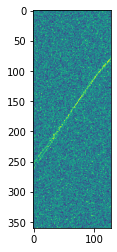

In [13]:
img = trn_ds[0]
plt.imshow(img[1].mean(0))

In [14]:
class CustomLoss(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss_func = loss_func
    
    def forward(self, output, mask, label):
        return self.loss_func(output * (1 - mask), label * (1 - mask))
        
        
    

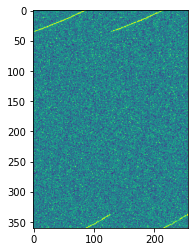

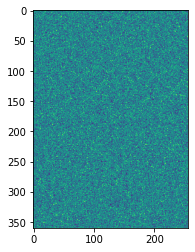

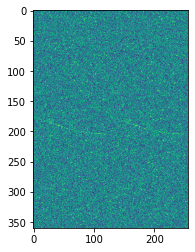

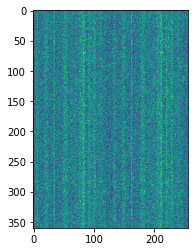

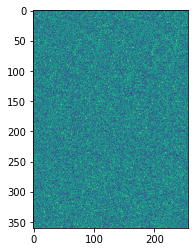

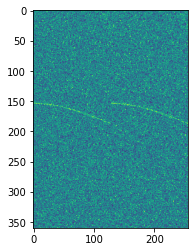

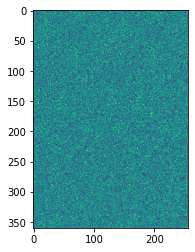

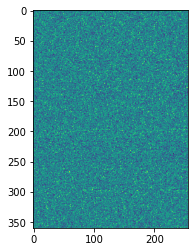

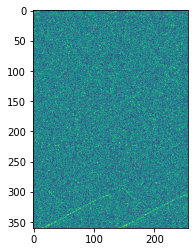

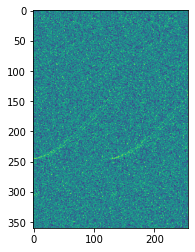

In [15]:



for i in range(10):
    img, y, _= trn_ds[np.random.randint(0, len(trn_ds))]
    customplot(torch.tensor(img), torch.tensor(y))
    plt.pause(0.1)
    #plt.figure(figsize=(8, 8))
    #plt.title('Spectrogram')
    #plt.xlabel('time')
    #plt.ylabel('frequency')
    #plt.imshow(img.mean(0))
    ##plt.imshow(np.concatenate([img[0], img[1]], 1))  # zooming in for dataset[10]
    #plt.colorbar()
    #plt.show()
    #print(y)
    #plt.pause(0.1)

   

In [16]:
trn_dl = DataLoader(
    trn_ds,
    batch_size=CFG.bs,
    shuffle=True,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=True,
)
vld_dl = DataLoader(
    vld_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
)
custom_model = SRMNet(in_chn=2)
custom_model.load_state_dict(torch.load('EXP_40_01_NV_TEST/EXP_40_01_NV_TEST_SRG_REAL_NOISE_TO_VOID_TEST_V_19_15.pth'))
opt = torch.optim.AdamW(custom_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
loss_func = CustomLoss(nn.L1Loss())
warmup_steps = int(len(trn_dl) * int(CFG.warmup_pct * CFG.epoch))
total_steps = int(len(trn_dl) * CFG.epoch)
sched = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

fit_mixup(
    epochs=CFG.epoch,
    model=custom_model,
    train_dl=trn_dl,
    valid_dl=vld_dl,
    loss_fn=loss_func,
    opt=opt,
    folder=CFG.folder,
    exp_name=f"{CFG.exp_name}",
    device="cuda:1",
    sched=sched,
)

epoch,train_loss,valid_loss
0,0.019235,0.019129
1,0.019234,0.019130
2,0.019236,0.019128
3,0.019232,0.019129
4,0.019236,0.019129
5,0.019234,0.019129
6,0.019234,0.019129
7,0.019234,0.019129
8,0.019233,0.019134
9,0.019235,0.019136


Better model found at epoch 0 with value: 0.019129442385720234.
Better model found at epoch 1 with value: 0.019130269910361358.
Better model found at epoch 2 with value: 0.01912822909968109.
Better model found at epoch 3 with value: 0.019129280431856417.
Better model found at epoch 4 with value: 0.01912904604695674.
Better model found at epoch 5 with value: 0.019129458300655943.
Better model found at epoch 6 with value: 0.019128895893702244.
Better model found at epoch 7 with value: 0.01912877106527873.
Better model found at epoch 8 with value: 0.01913406080922667.
Better model found at epoch 9 with value: 0.01913558810703172.
Better model found at epoch 10 with value: 0.019122720970447107.
Better model found at epoch 11 with value: 0.01912534085048333.
Better model found at epoch 12 with value: 0.019122076383391497.
Better model found at epoch 13 with value: 0.01912446754721627.
Better model found at epoch 14 with value: 0.019119474972274824.
Better model found at epoch 15 with value:

In [20]:
%debug

custom_model =  SRMNet(in_chn=2)
custom_model.load_state_dict(torch.load('EXP_40_01_NV_TEST_V2/EXP_40_01_NV_TEST_V2_SRG_REAL_NOISE_TO_VOID_TEST_V2_DATA_V31_29.pth'))
custom_model.cuda();
custom_model.eval();

ERROR:root:No traceback has been produced, nothing to debug.


In [21]:
#custom_model =  SRMNet(in_chn=2)
#custom_model.load_state_dict(torch.load('EXP_40_01_NV_TEST/EXP_40_01_NV_TEST_SRG_REAL_NOISE_TO_VOID_TEST_V_19_15.pth'))
#custom_model.cuda();
#custom_model.eval();

In [39]:
trn_df = pd.read_csv(CFG.split_voldf/'train_meta.csv')
trn_df = trn_df.query('snr>40 and snr < 50')
trn_ds = DataV0(trn_df, True)

43.65907331568145


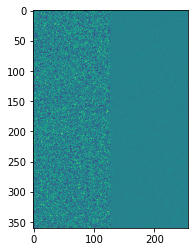

44.88318756334732


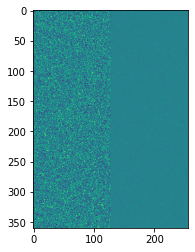

42.57309136772157


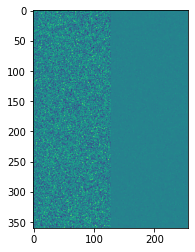

43.21104382181993


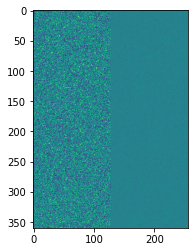

41.33752878069239


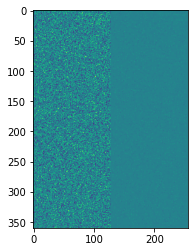

43.58775315897158


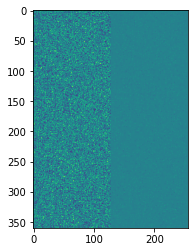

41.438248928438455


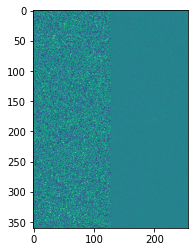

45.92805774208228


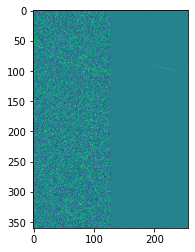

43.7507757754031


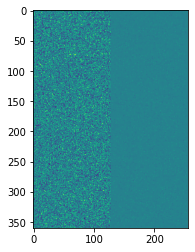

43.95907827391288


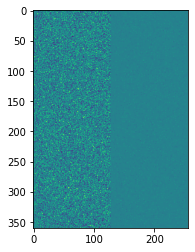

In [41]:
for k in range(10):
    #idx = np.random.randint(0, len(trn_ds))
    print(trn_ds.df.iloc[k].snr)
    img = torch.tensor(trn_ds[k][0]).unsqueeze(0)
    for i in range(1):
        with torch.no_grad():
            out = custom_model(img.cuda()).detach().cpu()
            customplot(img[0], out[0])
            plt.pause(0.1)

../data/test/00054c878.hdf5 0.077132255


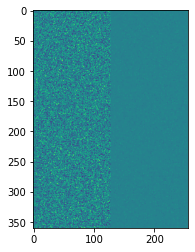

../data/test/0007285a3.hdf5 0.8486407


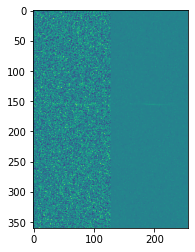

../data/test/00076c5a6.hdf5 0.10693246


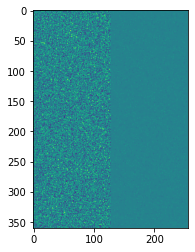

../data/test/001349290.hdf5 0.2560634


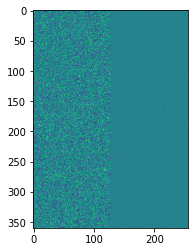

../data/test/001a52e92.hdf5 0.50730973


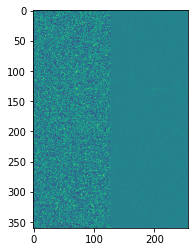

../data/test/00222d97b.hdf5 0.13845977


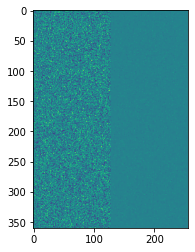

../data/test/00249c302.hdf5 0.11079024


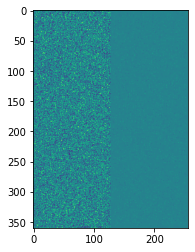

../data/test/0026862ce.hdf5 0.11513428


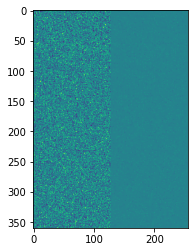

../data/test/00368b973.hdf5 0.3911178


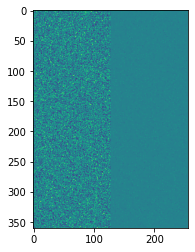

../data/test/003b7a1e9.hdf5 0.22922084


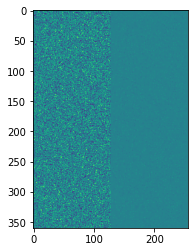

In [22]:

#maybe = ['b7a339801']
#submit = pd.read_csv('../data/sample_submission.csv')
#submit = submit.set_index('id').loc[maybe].reset_index()
#submit.columns = ['fn', 'target']
#submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test')/f'{x}.hdf5')
#submit.columns = ['id', 'target']

#df_test = pd.read_csv('../data/SUBS/submission_debias.csv')
#pos = ['008b91c55',
# '00bce5685',
# '00f226552',
# '012992291',
# '015bf0213',
# '017a7c7f1',
# '0195324d2',
# '01cb9865c']
#df_test = df_test.set_index('id').drop(pos).reset_index()
#df_test['id'] = df_test['id'].apply(lambda x: Path("../data/test/")/f"{x}.hdf5")
#
#trn_ds = DataV0(df_test, False)
#for k in range(10):
#    #idx = np.random.randint(0, len(trn_ds))
#    print(df_test.iloc[k].id, df_test.iloc[k].target)
#    img = torch.tensor(trn_ds[k][0]).unsqueeze(0)
#    for i in range(1):
#        with torch.no_grad():
#            out = custom_model(img.cuda()).detach().cpu()
#            customplot(img[0], out[0])
#            plt.pause(0.1)
#
#

In [ ]:
plt.imshow(out[0].mean(0), vmin=0, vmax=1)

In [ ]:
img = torch.tensor(vld_ds[0])
img.shape

In [ ]:
import h5py
class DataV0Valid():
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.freq_tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        filename=r.id
        file_id = Path(r.id).stem
        img = np.empty((2, 360, 128), dtype=np.float32)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64
                p = a.real**2 + a.imag**2  # power
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
                img[ch] = normalize(p, clip=True)
        if self.freq_tfms:
            if np.random.rand() <= 0.5: # horizonta
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= 0.5: # vertical 
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= 0.5: # vertical 
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
        img = torch.tensor(img)  
        return img
    
    



In [ ]:
pos = ["008b91c55", "00bce5685", "00f226552", "012992291", "015bf0213", "017a7c7f1", "0195324d2", "01cb9865c", "01dc5af02", "023aebec4", "028b6615d", "02c2e5de1", "0302d47d0", "030658180", "0354a13e2", "03717ca39", "04592c3d1", "047fb9ed5", "051895cd1", "05cad0ed3", "05eda6f5a", "0611d3c27", "0639bd69d", "0675028e4", "06ac9d3ea", "077a11239", "077a57010", "07b2073db", "07cd0847f", "07dd7e0e2", "08f6988f4", "092c9af35", "094687e08", "0a2e0807c", "0a61f1932", "0a9780441", "0a9def5f6", "0ae4c93c8", "0ae892b99", "0afa0bb1b", "0bce75cc0", "0bfb2a22e", "0c7f63a4c", "0cac0b665", "0d0fb754f", "0d16c6139", "0d70d7ce1", "0d9fd6c93", "0dcfb8530", "0dfe6acb4", "0e168818a", "0e26a554b", "0e33ca7db", "0eaafb22f", "0ebff2780", "0f9dd9eca", "0fefc4fd9", "1031d1f36", "1081950a3", "113e2e633", "11c6c76ab", "1242a70e8", "1286e574f", "12b3ae845", "12d8eed90", "12db0b252", "13731679d", "137a2ed27", "137d4d41b", "13ab0a0b2", "13c0417d6", "13c184cdc", "13ddf3c72", "147fbd0fe", "14d7c9498", "14dfefcd5", "14eb4a20c", "15149b585", "154e3c957", "15785900e", "15b0fd78b", "15ecfbf90", "15fc931ea", "161dff33f", "162395d96", "163f2d88e", "166baf13f", "166ffe397", "168f2a36c", "16a661528", "1764d7bf0", "17ecd00b9", "180d34e52", "180f77ac8", "183510397", "18448da35", "18d56acf1", "193667fcf", "1948c446d", "1979dbea3", "19c4818b5", "19cf5d868", "1a6246e1a", "1a695b048", "1aa71d63a", "1abc53c78", "1abdbf772", "1ad1b366d", "1aea74b40", "1b7608cf7", "1bdcfd1e6", "1cb847682", "1ce108de4", "1d986a4b5", "1df3960ac", "1e66dc097", "1ed98b2c2", "1f4dd9252", "1f9bb71c0", "20612b3e4", "20d6d3d11", "20e1dbc67", "210c5f6a1", "211108cc0", "218b75976", "21dd6365d", "221b920a4", "2221e08b4", "2232ffe30", "22b61b7b3", "22c61fa16", "234e172c0", "23c5d3107", "23d70e5d1", "23d90d609", "240789d04", "243845761", "248d86603", "249099ad6", "2498595ac", "24b4174cb", "25671a512", "257264706", "25b483fa0", "25cc60c9b", "26ca57eba", "275a2d879", "2761e4bad", "277238c02", "289b9b1d8", "28f679138", "291c8006b", "2955a55b1", "29873c606", "29f3d1ed5", "2a0159541", "2a12adffe", "2a180c12a", "2a78ef0cd", "2a870f928", "2abd229bc", "2ae002c3f", "2aea19b04", "2bb864b08", "2ca75fabd", "2cbdeb983", "2cbe330e0", "2ceb94002", "2d207c125", "2d2275bb5", "2d4b3758d", "2d57c9399", "2d5db8379", "2d757d2c1", "2d8486121", "2e5af1d8b", "2e86815e1", "2e9466aee", "2ec06617e", "2ec2db48d", "2f5dfb161", "2fc00284e", "2fe5f1717", "2fe8795d8", "30218f6ba", "3022e8994", "30240e8a5", "302a9cc68", "306bdc5c1", "309c1cc9e", "30c29d4ee", "3109af837", "3190f5826", "31a1ff060", "31ffa6934", "322046c4d", "3242d94d2", "3245cf936", "326a66010", "3279f4bba", "327d89e99", "32d5c7384", "32e593923", "3323888e7", "334680bd1", "336ed74d4", "337b82964", "338088eee", "33abc2840", "33ac02361", "34365c566", "3443e104d", "3485ed239", "34d9740b9", "3507e1515", "356e630ce", "35a5ef7d2", "35a67c429", "35e7353b3", "36625a7db", "3742aa18c", "3753e999c", "376ffab2d", "37bae074b", "381a9af29", "3885d0e1a", "388d00912", "38994676c", "38b2510ec", "39a264f07", "39add4593", "3a94e8b84", "3abcdaf6a", "3ac230af8", "3ae232a65", "3b54fbb0b", "3b6e7f0ac", "3c1fe0fb6", "3c84aad9a", "3caac79b1", "3cda37254", "3cff3d1df", "3db99e7cf", "3dc645474", "3dccf2e04", "3e3f4c2e5", "3e4a3c65a", "3e4b4a631", "3e503b700", "3e8a698ca", "3ed8f820b", "3f5849e72", "3f5be5bf5", "3fa023578", "3feac2d37", "4006adb1a", "40df3665f", "40e118e70", "41067c0bd", "412c5e57f", "41e5f7426", "41f4bd1b3", "42313a825", "4247e30cf", "426cadd53", "427e1391e", "42ca943d0", "42efccabf", "4337094c3", "435465a6a", "43ab3acba", "43fb14080", "4417a60ae", "44c13833b", "450f0b42f", "45b549521", "45e8578bc", "4641e706a", "465de42ff", "46684d694", "46cab26bb", "46ea07334", "473adc567", "473ef0b67", "4751cd02c", "4768dd659", "478547418", "47a217380", "47e64ebe7", "480eb7762", "48589b9ca", "485be1079", "48ac8d5c4", "494456b4c", "49cc0b77a", "49d9e7dad", "4a095dc42", "4a5e7564f", "4a620e20d", "4b1dc214e", "4c41ba002", "4c5343657", "4ca82fcd5", "4d0bba14e", "4d9b509f0", "4dff1cfb2", "4e03f621d", "4f306a341", "4f6265cfb", "4f69417cf", "50456e78c", "50851fe35", "50865063c", "50ab23095", "50feb40ff", "517f12b45", "51f813b14", "521704abd", "52186fb05", "523d37990", "529ad9fed", "5302a5c1d", "5329a429c", "53320e6bc", "53362e699", "5348aa921", "5376c9cac", "5388e737d", "53b80dcf4", "53bc73f80", "53c4b4b1a", "53ead9e8f", "53f254a5c", "5434a1eee", "546913595", "55179b353", "55465dae2", "556ee9c40", "5618591e4", "562c9d013", "56336430b", "56b57039a", "56e3a9c78", "56edbe968", "572ac63ea", "57e146d20", "58d8aeb84", "59a6a4b02", "59b1791b4", "59f188a9f", "5a36b5407", "5ab02c27d", "5b122cc22", "5b3e96840", "5b7871232", "5b8a21b44", "5bb4aa235", "5bbd60669", "5c7713b7a", "5ccee0125", "5cef1993d", "5cf106611", "5dc1bab81", "5e12c0d48", "5e4a83024", "5f90f5bc9", "5f99503fd", "5f9a1ef53", "5faac0b36", "5ffd1f11a", "60380ce6d", "603dbb7b9", "608c2d607", "60b86e780", "60e18e479", "61183e510", "611b863fd", "615e4bcf6", "615f76e28", "616339a77", "61682b309", "61b9d669e", "628f43ef0", "62dc61c11", "62e469f67", "630d8cc86", "632870895", "634a9528f", "63518bd39", "63bd7e7de", "63edc2e4f", "63efe2c16", "6478d9d02", "649652bbd", "64b4f83b6", "64b8fa1fa", "6509ebfa6", "651668d15", "651de73fa", "65289fa27", "657ae82b3", "657ebf705", "659945133", "65dacb72d", "65dbc156d", "66e20bdbc", "6753d332c", "67c98515f", "6862e262c", "687891898", "68d6e5e02", "68ebd9148", "69ad5230b", "69f5bf408", "6aa93b740", "6b014dd4a", "6b56645ec", "6b610a30e", "6b65bd089", "6b6faf1da", "6b7099148", "6b8655c14", "6bd915dd1", "6be9fd24d", "6c14a4f3f", "6c3c3e3b4", "6c7032492", "6c735c1e4", "6d24da6f2", "6d6c10816", "6d7d7ae6e", "6dccc5fe9", "6e4e39262", "6e63e80b4", "6ec60dc8f", "6fb096f56", "6feef7863", "7013e82bb", "709f52e60", "70a9bab8e", "711f82733", "712a1e583", "71e9a45de", "720ed4c62", "7265d9605", "73281d4ef", "7335f79ff", "73ec484a3", "741b6a3a3", "745164304", "7456ed1d3", "749d5249c", "752b5cf52", "7537c3e7f", "755d947a2", "75ac44aff", "7655b2d3c", "76e40fc8a", "7709f0194", "7715b67f2", "771f29ac3", "779f7cdd7", "77c3a6877", "780936b0d", "781ede24b", "784cef59b", "785001f55", "785011ce6", "78a3facc4", "78c328627", "78f2a09b1", "793bc5ca2", "793c2bc40", "7971e3fa2", "7982939f2", "7a1eb66cd", "7a4c3b959", "7a7f1a9c1", "7a9421439", "7ad6a95c1", "7b1f9f4a4", "7bf732340", "7c251f371", "7c37fb90d", "7e7192783", "7e8a33986", "7f343a951", "7f18dcb24", "7fb749b67", "8008b5751", "805264555", "80c9d62f7", "80f7a5168", "818a4f930", "81c8ae37f", "81d69558d", "81d93c6fa", "81ed35f3d", "82d25d2a7", "835e95505", "8365381ee", "83684c02b", "83873a300", "846259c61", "8485c991b", "849cbfcbf", "84a7327bc", "84ed19a7d", "856831ddf", "861240b40", "861b2119e", "86531152e", "867293db6", "8707988b8", "87136e3c4", "8819b75c6", "881ee1435", "88bffad32", "88e3a7747", "88ec93a19", "894a5a054", "8972c5591", "897d945ce", "8992e892e", "899f60a37", "8a4830756", "8aa5137a5", "8ab48304e", "8b48760a4", "8ba318040", "8c0471631", "8c103dd7d", "8c4642358", "8c722d417", "8c7d6c68a", "8cdab6dfb", "8cdef8adf", "8ce510886", "8d0873458", "8daf59cf1", "8de46bd52", "8e6048ed6", "8e7a9c60e", "8e9e3c11e", "8eb077696", "8edd10d8c", "8f41cb705", "8fea9a7cb", "901fde144", "9048ae8d0", "907ce79d9", "908d06ba1", "9145337f5", "916e7034f", "9186fe6d5", "91b6b60bc", "91f7fed7f", "927dfd49a", "92845e015", "93143054e", "9316bf46e", "9326252a8", "93dd663b6", "93e150893", "93ec07f9e", "95fe6b82b", "964f27e0b", "96a527a7d", "9717b6d76", "9727a02cc", "983a9616f", "98b8bf99d", "b21dac14c", "9951f9a1e", "996b2b55e", "99a8c8e67", "99b1f29c4", "99c8b63f1", "9a1f34301", "9b1c22a2f", "9b3968afa", "b8f8ba393", "9b5b33610", "9b8de9d8e", "9b9d80b0e", "9c02351ec", "9c02b193b", "9c060f0f4", "9c59d4cc1", "9c6c67747", "9c816769d", "9d13239ac", "9d37c620d", "9d58201e6", "9d7676848", "9e49c9fe4", "9e5143dd1", "9f1b0e62e", "9f5acbd94", "9f635d10d", "a00adfc84", "a01663464", "a06ce46d7", "a0e9925da", "a12b21258", "a13581e65", "a14506109", "a18613f2c", "a18ae6248", "a22464405", "a251743b4", "a2a0c2602", "a2e7ee5ac", "a3349d5b1", "a356ae34a", "a411ad130", "a42f5bd64", "a438c6cfc", "a448b8a13", "a47c5095a", "a51035b48", "a516aa9d6", "a5c39d5fe", "a733a9c7e", "a77da0f78", "a7a6015e0", "a7b12149e", "a85fc17f2", "a8aaa9755", "a8fefe2a5", "a91b62430", "a5c65d974", "a62f12b24", "a67f981fd", "a2f07fb2f", "a18bc84df", "a1b093860", "a93def817", "a9952664f", "eec309fff", "a9b4113f2", "a9d495532", "aa6b261d0", "aa96b3b06", "aaaef2162", "aab94bc44", "aabb2146f", "aaebed8e4", "aaeec0efa", "aaeff1b1e", "ab6bc8ecd", "abbe7c13d", "abcc88fdd", "abd339ec4", "ac1337358", "ac53d47ad", "ac87e419a", "ac88721bc", "acf8ccc40", "ad0ca4433", "ad0f2b63d", "ad133a4d0", "ad16a18cc", "ad2b53cb7", "ad748627c", "ad811541d", "adc7f1815", "ae62f85b5", "aeb84922d", "aee0d611a", "aef497077", "af0650f97", "b0f663708", "b12a39a61", "af1c3875b", "afb6c2dd7", "b0b623f5f", "b0882b4f2", "b21f70e58", "b2398cf5a", "b2b499d55", "b2c3bd2b6", "b332c2280", "b33c5a1a9", "b33c84c79", "b390b1096", "b3c6a59e3", "b43ba01f7", "b441ab24d", "b49efab84", "b530f8500", "b56cd92fa", "b5a332c7e", "b5d96a94a", "b5fd076d5", "b61008f30", "b68b3717a", "b69344a7d", "b69b880b4", "b6b09f76f", "b6f7d69fe", "b788b3f0f", "b7a7124cc", "b95187d0f", "b8ad556f9", "ba07b9867", "ba95eaab1", "bac6869fa", "bb2be9d77", "bba80c75f", "bbe7f9004", "bc90bb755", "bcb219458", "bd8f3ae41", "bd957074c", "be1c90c04", "be3687c7b", "bf3baa13d", "bf8c2b7c6", "c08f7fbd7", "c0c4c60f7", "c0f0b6cbb", "c1304726c", "c18c03cce", "c246343a6", "c26d53aa8", "c2706f0d0", "c318bba91", "c374ae4ef", "c3ec88602", "c431f2c73", "c48417c68", "c487fd70a", "c4df9d520", "c4fb64948", "c5578c571", "c58707581", "c5dbbca3b", "c5e3703b4", "c5f358792", "c61c091ac", "c70580b6c", "c71d8f370", "c75b9f898", "d29c12463", "d29ed865b", "d2e9a7d91", "d31406fee", "d31c57943", "d3380574f", "d385a0e12", "d3d6a395f", "d40a93867", "d41571ec9", "c7bebeb57", "c80a6e98a", "c80dd37b5", "c85e2e52a", "c86aa34bd", "c88c13b54", "c8c196906", "c90947444", "c96257fda", "ca2eec779", "cad4c86af", "cb11c603e", "cb19344d7", "cb7527171", "cbdadbf8a", "ccb2a29e3", "cd2189e5b", "cd3d4d43b", "cd665c616", "ce96dda82", "cf734d970", "cf9e856c5", "d06d63717", "d09f002bc", "d0b436a4f", "d0d10f455", "d0e1a6e8f", "d11b436e0", "d19925d1e", "d1ae07eb0", "d2132510e", "d23456c22", "d253828d4", "be4c0fd79", "b8d6b62dc", "d4e46b35f", "d4f53a225", "d5068ef03", "d50959802", "d53836de7", "d65d8383c", "d65e984f5", "d66725634", "d6cc47115", "d7041d2f4", "d718c0c29", "d72c3c2b2", "d754b6e93", "d7896aa92", "d79369a45", "d7b4ae67f", "d84e5488c", "d87cae503", "d87dcff97", "d8c3a2fc3", "d980b72d2", "d98e85a30", "d9bbdfe61", "d9ef85811", "da02dba51", "da17124e2", "db51761bd", "db800e410", "dc154cbb6", "dc20f8235", "be92c0706", "dc5116c0e", "dc68cab42", "dcfe9fe0f", "dd17b2712", "dd34ee959", "dfe979f1e", "deceb9082", "de003310a", "e124f4193", "e13312e60", "e1aa595c3", "e1c01fc80", "e2256cda9", "e2b58e3c5", "e2fa690a6", "e3799feb7", "e464b5578", "e4d6595d9", "e4d9ba120", "e5d46958e", "e5f047e81", "e5f557194", "e63b7654c", "e66013433", "e66f556b6", "e69e73c5d", "e6fa44fad", "e72d0cb27", "e72ec8893", "e75cc612c", "e76e00ffd", "e77849eff", "e7add04bb", "e7b9985a1", "e80e4042a", "e80e8be07", "e81122168", "e8118e55a", "e83141ee0", "e836946fc", "e90fe12f0", "e9a3d272f", "e9c4184fb", "ea03499ad", "ea057ff4c", "ea06c71cc", "ea0c1cb53", "ea59736e8", "ea6ff462e", "eb1fc0362", "eb3b88eee", "eba37c86c", "ebeb1ca65", "ecb33e062", "ed5246714", "ed6570249", "ed890e6b6", "edce6c418", "ee1f17704", "ee539abc8", "ee715a1e6", "ee8bd4691", "ee8f4b623", "eea970dfe", "e541abebb", "eecbc5c13", "eedd028e5", "eee7e0089", "eef41eeca", "ef595803b", "ef873032d", "ef90af2fa", "efb9b702a", "efc1939c3", "efecaf2fd", "f01f87a8f", "f0428245c", "f05ffe684", "f0ac08475", "f0fb1a4c4", "f10bacca1", "f10c9650f", "f122aab40", "f12e585bd", "f130b46d5", "f18167fe9", "f1a7495c4", "f1b072728", "f1be87e8a", "f1ea39a00", "f2ac2edec", "f33e73f62", "f3c4a98d8", "f45d55487", "f4963046e", "f4a6d1f78", "f4b45a8d3", "f4b7c4a65", "f4decfaac", "f5130711a", "f532ff155", "f57956a07", "f589dc73c", "f59fed8e1", "f5d25af84", "f5da51794", "f5df65e7b", "f5e17620d", "f66c7b189", "f7381d1d0", "f740d80e1", "f7548d0eb", "f7b345696", "f84220402", "f859e555e", "f8935ae34", "f8b66e6cf", "f8ca6362d", "f99431b7d", "fa400f328", "fa4cf3589", "fa504210e", "faa36bae5", "faa696b45", "fb1e0df09", "fb58bad13", "fc2271359", "fc42166c0", "fd0bde745", "fd95e737e", "fdbf65da4", "fe2331b38", "fe3983d5d", "feed886fe", "ffb5b60b1", "e59997ccd"]
comp  = ["017a7c7f1", "01cb9865c", "01dc5af02", "023aebec4", "047fb9ed5", "0611d3c27", "0675028e4", "077a57010", "0d0fb754f", "0d16c6139", "1242a70e8", "1286e574f", "13731679d", "14d7c9498", "14dfefcd5", "15149b585", "15b0fd78b", "180d34e52", "1a6246e1a", "1aa71d63a", "1bdcfd1e6", "20d6d3d11", "211108cc0", "21dd6365d", "249099ad6", "24b4174cb", "25cc60c9b", "29873c606", "2a0159541", "2a180c12a", "2ae002c3f", "2cbdeb983", "2cbe330e0", "2d5db8379", "3022e8994", "3109af837", "31a1ff060", "326a66010", "327d89e99", "336ed74d4", "3abcdaf6a"]
prob_no = [ "dee7c8d0f", "6ef79f3e4", "b1ce28bbb", "a1f9b8e82", "b95698658", "7341591b0", "b0990161d", "71051c674", "7ee0a00f8", "a015abc2e", "895b27680", "7c7d5b29c", "ddd8c6e90", "80b695868", "8b180f74f", "e08f4e117", "dc2aaaee9", "93364a2e2", "9f37c3fde", "82d846e01", "8930668af", "87c1d57ad", "81fd533ac", "9d340855d"]
submit = pd.read_csv('../data/sample_submission.csv')
#submit = submit.set_index('id').loc[pos].reset_index()
submit.columns = ['fn', 'target']
submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test')/f'{x}.hdf5')
submit.columns = ['id', 'target']

In [ ]:
tst_ds = DataV0Valid(submit)

In [ ]:
for k in range(50):
    img = tst_ds[np.random.randint(0, len(tst_ds))].unsqueeze(0)
    with torch.no_grad():
        out = custom_model(img.cuda()).detach().cpu()
        customplot(img[0], out[0])
        plt.pause(0.1)



In [ ]:
out.min()

In [ ]:
out.max()

In [ ]:
ou